---
title: Assignment 04
subtitle: "Regression Analysis in Pyspark"
author:
  - name: Tracy Anyasi
    affiliations:
      - id: bu
        name: Boston University
        city: Boston
        state: MA
number-sections: true
date: '2025-10-08'
date-modified: today
date-format: long
format:
  html:
    theme: cerulean
    toc: true
    toc-depth: 2

execute:
  echo: false
  eval: false
  freeze: auto
---

In [3]:
from pyspark.sql import SparkSession
import pandas as pd
import plotly.express as px
import plotly.io as pio
import numpy as np

np.random.seed(42)

pio.renderers.default = "notebook+notebook_connected+vscode"

# Initialize Spark Session
spark = SparkSession.builder.appName("LightcastData").getOrCreate()

# Load Data
df = spark.read.option("header", "true").option("inferSchema", "true").option("multiLine","true").option("escape", "\"").csv("./data/lightcast_job_postings.csv")

# Show Schema and Sample Data
print("---This is Diagnostic check, No need to print it in the final doc---")

# df.printSchema() # comment this line when rendering the submission
df.show(5)

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/10/05 23:28:39 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


---This is Diagnostic check, No need to print it in the final doc---


25/10/05 23:28:56 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+--------------------+-----------------+----------------------+----------+--------+---------+--------+--------------------+--------------------+--------------------+-----------+-------------------+--------------------+--------------------+---------------+----------------+--------+--------------------+-----------+-------------------+----------------+---------------------+-------------+-------------------+-------------+------------------+---------------+--------------------+--------------------+--------------------+-------------+------+-----------+----------------+-------------------+---------+-----------+--------------------+--------------------+-------------+------+--------------+-----+--------------------+-----+----------+---------------+--------------------+---------------+--------------------+------------+--------------------+------------+--------------------+------+--------------------+------+--------------------+------+--------------------+------+--------------------+------+------

## Feature Engineering

Remove incomplete data, keep relevant variables, and iron out complicated string values
Encoder turns categorical columns (remote, hybrid, onsite) to numeric ones (1 or 0) based on input

In [4]:
#| eval: true
#| echo: falase
#| fig-align: center

from pyspark.sql.functions import col, pow, when
from pyspark.ml.feature import StringIndexer, VectorAssembler, OneHotEncoder
from pyspark.ml import Pipeline

#remove rows with NAs
df_cleaned = df.dropna(subset=[
    "SALARY", "MIN_YEARS_EXPERIENCE", "STATE_NAME", "EMPLOYMENT_TYPE_NAME",
    "REMOTE_TYPE_NAME", "MIN_EDULEVELS_NAME", "DURATION", 
    "IS_INTERNSHIP", "COMPANY_IS_STAFFING"
])

eda_cols = [
    "SALARY", "MIN_YEARS_EXPERIENCE", "DURATION", "COMPANY_IS_STAFFING",
    "IS_INTERNSHIP", "STATE_NAME", "REMOTE_TYPE_NAME",
    "EMPLOYMENT_TYPE_NAME", "MIN_EDULEVELS_NAME"
]
df_cleaned = df_cleaned.select(eda_cols)

#clean up REMOTE_TYPE_NAME and reduce the different inputs
df_cleaned = df_cleaned.withColumn(
    "REMOTE_TYPE_NAME",
    when(col("REMOTE_TYPE_NAME") == "Remote", "Remote")
    .when(col("REMOTE_TYPE_NAME") == "[None]", "Undefined")
    .when(col("REMOTE_TYPE_NAME") == "Not Remote", "On Premise")
    .when(col("REMOTE_TYPE_NAME") == "Hybrid Remote", "Hybrid")
    .when(col("REMOTE_TYPE_NAME").isNull(), "On Premise")
    .otherwise(col("REMOTE_TYPE_NAME"))
)

#clean EMPLOYMENT_TYPE_NAME
df_cleaned = df_cleaned.withColumn(
    "EMPLOYMENT_TYPE_NAME",
    when(col("EMPLOYMENT_TYPE_NAME") == "Part-time / full-time", "Flexible")
    .when(col("EMPLOYMENT_TYPE_NAME") == "Part-time (â‰¤ 32 hours)", "Parttime")
    .when(col("EMPLOYMENT_TYPE_NAME") == "Full-time (> 32 hours)", "Fulltime")
    .when(col("EMPLOYMENT_TYPE_NAME").isNull(), "Fulltime")
    .otherwise(col("EMPLOYMENT_TYPE_NAME"))
)

#df_cleaned = df_cleaned.filter(col("REMOTE_TYPE_NAME") != "Undefined") -- initially wnated to remove the undefined but it dropped the
#percentage of the regression model

# Categorical and numeric columns
categorical_cols = ["EMPLOYMENT_TYPE_NAME", "REMOTE_TYPE_NAME"]
continuous_cols = ["MIN_YEARS_EXPERIENCE", "DURATION", "IS_INTERNSHIP", "COMPANY_IS_STAFFING"]

# Index and One-Hot Encode
indexers = [StringIndexer(inputCol=col, outputCol=f"{col}_Idx", handleInvalid="skip") for col in categorical_cols]
encoders = [OneHotEncoder(inputCol=f"{col}_Idx", outputCol=f"{col}_vec") for col in categorical_cols]


In [5]:
# combines all categorical and numeric columns into one vector coulmn
assembler = VectorAssembler(
    inputCols=continuous_cols + [f"{col}_vec" for col in categorical_cols],
    outputCol="features"
)

#create pipeline for sequential transformation
pipeline = Pipeline(stages=indexers + encoders + [assembler])
data = pipeline.fit(df_cleaned).transform(df_cleaned)

# polynomial regression for MIN_YEARS_EXPERIENCE
data = data.withColumn("MIN_YEARS_EXPERIENCE_SQ", pow(col("MIN_YEARS_EXPERIENCE"), 2))

#assemble og features plus poly feature into new feature vector
assembler_poly = VectorAssembler(
    inputCols=["features", "MIN_YEARS_EXPERIENCE_SQ"],
    outputCol="features_poly"
)
data = assembler_poly.transform(data)

#split data into training and testing sets for model evaluation
reg_train, reg_test = data.randomSplit([0.8, 0.2], seed=51)
#This split reserves 80% of the data for training and 20% for testing which provides enough data for the model to learn while keeping a reliable holdout set for evaluation.

#displays final structure with salary as target
data.select("SALARY", "features", "features_poly").show(5, truncate=False)

+------+--------------------------------------+-------------------------------------------+
|SALARY|features                              |features_poly                              |
+------+--------------------------------------+-------------------------------------------+
|192800|(9,[0,1,4,6],[6.0,55.0,1.0,1.0])      |(10,[0,1,4,6,9],[6.0,55.0,1.0,1.0,36.0])   |
|125900|(9,[0,1,4,6],[12.0,18.0,1.0,1.0])     |(10,[0,1,4,6,9],[12.0,18.0,1.0,1.0,144.0]) |
|118560|[5.0,20.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0]|[5.0,20.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,25.0]|
|192800|(9,[0,1,4,6],[6.0,55.0,1.0,1.0])      |(10,[0,1,4,6,9],[6.0,55.0,1.0,1.0,36.0])   |
|116500|(9,[0,1,4,6],[12.0,16.0,1.0,1.0])     |(10,[0,1,4,6,9],[12.0,16.0,1.0,1.0,144.0]) |
+------+--------------------------------------+-------------------------------------------+
only showing top 5 rows


In [6]:
for col in categorical_cols:
    indexer = StringIndexer(inputCol=col, outputCol=f"{col}_Idx", handleInvalid="skip")
    model = indexer.fit(df_cleaned)
    print(f"\nMapping for {col}:")
    for i, category in enumerate(model.labels):
        print(f"  Index {i} -> {category}")



Mapping for EMPLOYMENT_TYPE_NAME:
  Index 0 -> Fulltime
  Index 1 -> Parttime
  Index 2 -> Flexible



Mapping for REMOTE_TYPE_NAME:
  Index 0 -> Undefined
  Index 1 -> Remote
  Index 2 -> Hybrid
  Index 3 -> On Premise


## Linear Regression

In [7]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
import pandas as pd
from scipy.stats import t

lin_reg = LinearRegression(featuresCol="features", labelCol="SALARY")

lin_reg_fit = lin_reg.fit(reg_train) #fit model to training data

salary_pred = lin_reg_fit.transform(reg_test) #predicting on test data

#define the evaluators
r2_eval = RegressionEvaluator(labelCol="SALARY", predictionCol="prediction", metricName="r2")
rmse_eval = RegressionEvaluator(labelCol="SALARY", predictionCol="prediction", metricName="rmse")
mae_eval = RegressionEvaluator(labelCol="SALARY", predictionCol="prediction", metricName="mae")

#generate metrics
r2_score = r2_eval.evaluate(salary_pred)
rmse_val = rmse_eval.evaluate(salary_pred)
mae_val = mae_eval.evaluate(salary_pred)

print(f"R² Score: {r2_score:.4f}")
print(f"RMSE: {rmse_val:.2f}")
print(f"MAE: {mae_val:.2f}")


25/10/05 23:29:25 WARN Instrumentation: [68f324e3] regParam is zero, which might cause numerical instability and overfitting.


R² Score: 0.2840
RMSE: 35315.94
MAE: 27676.61


In [8]:
#getting coefs and stats
model_summary = lin_reg_fit.summary

coefs = lin_reg_fit.coefficients
intercept_val = lin_reg_fit.intercept
stderr = model_summary.coefficientStandardErrors
t_vals = model_summary.tValues
p_vals = model_summary.pValues

#compute degrees of freedom for t-distribution
n_obs = model_summary.numInstances
num_features = len(coefs)
dfree = n_obs - num_features - 1

#critical t-value for 95% CI
t_crit = t.ppf(0.975, dfree)

feature_labels = [
    "MIN_YEARS_EXPERIENCE",
    "DURATION",
    "IS_INTERNSHIP",
    "COMPANY_IS_STAFFING",
    "EMPLOYMENT_TYPE_NAME_A",
    "EMPLOYMENT_TYPE_NAME_B",
    "REMOTE_TYPE_NAME_X",
    "REMOTE_TYPE_NAME_Y",
    "REMOTE_TYPE_NAME_Z"
]

coef_table = pd.DataFrame({
    "Feature": ["Intercept"] + feature_labels,
    "Estimate": [intercept_val] + coefs.tolist(),
    "Std Error": stderr,
    "t-Stat": t_vals,
    "p-Value": p_vals
})

#add confidence intervals
coef_table["95% CI Lower"] = coef_table["Estimate"] - t_crit * coef_table["Std Error"]
coef_table["95% CI Upper"] = coef_table["Estimate"] + t_crit * coef_table["Std Error"]

print("\nCoefficient Summary:")
print(coef_table)


Coefficient Summary:
                  Feature      Estimate    Std Error     t-Stat       p-Value  \
0               Intercept  76735.577948   102.356000  66.277489  0.000000e+00   
1    MIN_YEARS_EXPERIENCE   6783.898664    23.632630  -1.831651  6.702934e-02   
2                DURATION    -43.286721  6866.446762  -1.025459  3.051684e-01   
3           IS_INTERNSHIP  -7041.257613  1063.265929  -0.595172  5.517402e-01   
4     COMPANY_IS_STAFFING   -632.826152  3011.540238  -0.421858  6.731367e-01   
5  EMPLOYMENT_TYPE_NAME_A  -1270.441524  3605.833255  -1.077711  2.811853e-01   
6  EMPLOYMENT_TYPE_NAME_B  -3886.046755  2462.498142   3.306373  9.480161e-04   
7      REMOTE_TYPE_NAME_X   8141.937756  2529.947825   3.635882  2.782402e-04   
8      REMOTE_TYPE_NAME_Y   9198.592476  3172.252546   7.636575  2.398082e-14   
9      REMOTE_TYPE_NAME_Z  24225.144004  3579.670705  21.436491  0.000000e+00   

   95% CI Lower  95% CI Upper  
0  76534.942765  76936.213130  
1   6737.574686   6830

The linear regression model explains approximately 28% of the variance in salaries, showing that while job attributes like as experience and remote status influence pay, substantial variation remains unexplained. This is likely due to qualitative factors like role seniority, company size, or negotiation effects. Undefined roles were initally excluded but that reduced the model's reliabilty and was subsequentially added as a baseline for remote roles.

Some statistically significant predictors include remote and hybrid roles (Remote Type X & Y) and Flexible employment type, all of which show clear positive or negative salary impacts. Compared to the baseline groups (Fulltime employment and Undefined remote), Flexible roles pay significantly less than Fulltime roles, whereas Parttime roles do not show a significant difference. For remote types, Remote, Hybrid, and On Premise roles show meaningful salary increases relative to Undefined roles, with On Premise roles exhibiting the largest premium of approximately $24K. 

Non-significant coefficients, such as Parttime or certain remote categories, suggest that observed differences may be due to random variation rather than a true effect, while the significant predictors highlight areas where job structure meaningfully affects compensation.

## Polynominal Linear Regression

In [11]:
from pyspark.ml.regression import LinearRegression
import pandas as pd
from scipy.stats import t

#train poly
poly_lr = LinearRegression(featuresCol="features_poly", labelCol="SALARY", solver="normal")
poly_model = poly_lr.fit(reg_train)  # use your training set

#get summary
summary_poly = poly_model.summary

#get regression stats and coeff
coefficients_poly = poly_model.coefficients
intercept_poly = poly_model.intercept
std_errors_poly = summary_poly.coefficientStandardErrors
t_values_poly = summary_poly.tValues
p_values_poly = summary_poly.pValues

#degrees of freedom
n_poly = summary_poly.numInstances
p_poly = len(coefficients_poly)
dof_poly = n_poly - p_poly - 1

# Critical t-value for 95% confidence interval
critical_value_poly = t.ppf(0.975, dof_poly)

feature_poly_names = [
    "MIN_YEARS_EXPERIENCE", "MIN_YEARS_EXPERIENCE_SQ",
    "DURATION",
    "IS_INTERNSHIP", "COMPANY_IS_STAFFING",
    "EMPLOYMENT_TYPE_NAME_A",  
    "EMPLOYMENT_TYPE_NAME_B",
    "REMOTE_TYPE_NAME_X",
    "REMOTE_TYPE_NAME_Y",
    "REMOTE_TYPE_NAME_Z"
]

#create df
coef_poly_df = pd.DataFrame({
    "Feature": ["Intercept"] + feature_poly_names,
    "Coefficient": [intercept_poly] + coefficients_poly.tolist(),
    "Std Error": std_errors_poly,
    "t-value": t_values_poly,
    "p-value": p_values_poly
})

#add CI
coef_poly_df["95% CI Lower"] = coef_poly_df["Coefficient"] - critical_value_poly * coef_poly_df["Std Error"]
coef_poly_df["95% CI Upper"] = coef_poly_df["Coefficient"] + critical_value_poly * coef_poly_df["Std Error"]

print(coef_poly_df)

#evaluate model on test set
predictions_poly = poly_model.transform(reg_test)

from pyspark.ml.evaluation import RegressionEvaluator

r2_eval = RegressionEvaluator(labelCol="SALARY", predictionCol="prediction", metricName="r2")
rmse_eval = RegressionEvaluator(labelCol="SALARY", predictionCol="prediction", metricName="rmse")
mae_eval = RegressionEvaluator(labelCol="SALARY", predictionCol="prediction", metricName="mae")

r2 = r2_eval.evaluate(predictions_poly)
rmse = rmse_eval.evaluate(predictions_poly)
mae = mae_eval.evaluate(predictions_poly)

print(f"Polynomial Regression R²: {r2}")
print(f"Polynomial Regression RMSE: {rmse}")
print(f"Polynomial Regression MAE: {mae}")


25/10/05 23:29:51 WARN Instrumentation: [48c15026] regParam is zero, which might cause numerical instability and overfitting.


                    Feature   Coefficient    Std Error    t-value  \
0                 Intercept  67932.172201   365.427981  34.124107   
1      MIN_YEARS_EXPERIENCE  12469.903484    23.369295  -1.746680   
2   MIN_YEARS_EXPERIENCE_SQ    -40.818670  6795.398159  -0.378451   
3                  DURATION  -2571.726155  1051.916215  -1.110934   
4             IS_INTERNSHIP  -1168.609779  2990.337025  -1.899043   
5       COMPANY_IS_STAFFING  -5678.777125  3572.973249  -2.128946   
6    EMPLOYMENT_TYPE_NAME_A  -7606.667528  2435.260898   3.109557   
7    EMPLOYMENT_TYPE_NAME_B   7572.582266  2501.762396   3.565968   
8        REMOTE_TYPE_NAME_X   8921.205741  3137.964205   7.286182   
9        REMOTE_TYPE_NAME_Y  22863.778828    26.275186 -16.193368   
10       REMOTE_TYPE_NAME_Z   -425.483749  3581.211738  18.969047   

         p-value  95% CI Lower  95% CI Upper  
0   0.000000e+00  67215.871148  68648.473253  
1   8.071963e-02  12424.095687  12515.711281  
2   7.051025e-01 -13360.955886

Polynomial Regression R²: 0.3016947273606302
Polynomial Regression RMSE: 34875.92736404874
Polynomial Regression MAE: 27190.399586682357


The polynomial regression model explains about 30% of the variance in salaries, showing that experience and job attributes influence pay, though much variation still remains unexplained. Significant predictors include remote and hybrid roles and all employment types meaningfully impact salaries.

Non-significant terms with limited contributions, such as the quadratic minimum years of experience term, has a negative coefficient while the linear minimum years of experience is positive, suggesting that althought salary increaes with more experience, the increase slows down as experience grows and plateaus. Overall, the model highlights which job characteristics most strongly affect compensation while capturing some non-linear effects of experience.

## Random Forest Regressor

In [ ]:
from pyspark.ml.regression import RandomForestRegressor

# choose hyperparameters 
num_trees = 450
max_depth = 7

#make RFR
rf = RandomForestRegressor(featuresCol="features", labelCol="SALARY", 
                           numTrees=num_trees, maxDepth=max_depth, seed=51)

#fitting the model
rf_model = rf.fit(reg_train)

#predictors
predictions_rf = rf_model.transform(reg_test)
predictions_rf.select("SALARY", "prediction").show(5)

print("Feature Importances:", list(rf_model.featureImportances))


25/10/05 23:30:40 WARN DAGScheduler: Broadcasting large task binary with size 1210.5 KiB
25/10/05 23:30:43 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
25/10/05 23:30:48 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
25/10/05 23:30:55 WARN DAGScheduler: Broadcasting large task binary with size 6.1 MiB
25/10/05 23:31:01 WARN DAGScheduler: Broadcasting large task binary with size 1402.3 KiB


+------+------------------+
|SALARY|        prediction|
+------+------------------+
| 29120|114624.66663326925|
| 31200| 96687.65499926287|
| 31200|114624.66663326925|
| 31640| 96228.91630692781|
| 32240| 95844.37906654779|
+------+------------------+
only showing top 5 rows
Feature Importances: [np.float64(0.8681171759565247), np.float64(0.06743212825429395), np.float64(0.0016313701554676735), np.float64(0.007622290249534043), np.float64(0.009574155828520737), np.float64(0.008389185582000717), np.float64(0.009964903639168394), np.float64(0.009171279424142545), np.float64(0.018097510910347166)]


# Feature Importance Plot

/tmp/ipykernel_1623/862456364.py:36: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




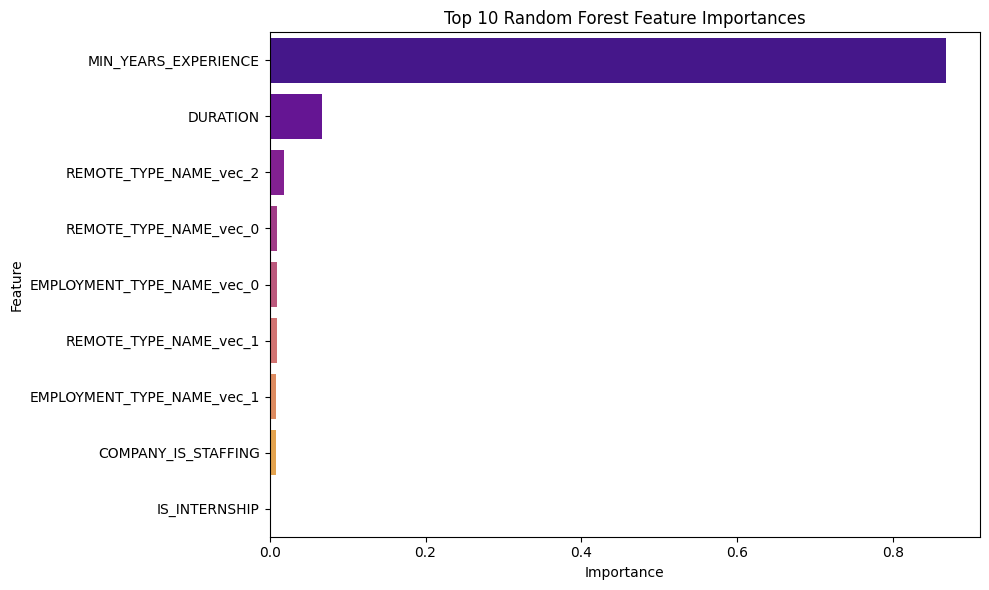

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.ml.feature import VectorAssembler

# Get all input columns from your assembler
feature_cols = assembler.getInputCols()

#flatten vectored columns to match feature vector
flattened_features = []
for col_name in feature_cols:
    dtype = dict(data.dtypes)[col_name]
    if dtype.startswith("vector"):
        # Get size of vector column
        vec_size = len(data.select(col_name).head()[0])
        flattened_features.extend([f"{col_name}_{i}" for i in range(vec_size)])
    else:
        flattened_features.append(col_name)

#extract feature importances from the RFR
importances = rf_model.featureImportances.toArray()

#create df
feat_imp_df = pd.DataFrame({
    "Feature": flattened_features,
    "Importance": importances
})

#sort and select top 10
top_feats = feat_imp_df.sort_values(by="Importance", ascending=False).head(10)

plt.figure(figsize=(10,6))
sns.barplot(x="Importance", y="Feature", data=top_feats, palette="plasma")
plt.title("Top 10 Random Forest Feature Importances")
plt.tight_layout()
plt.show()


This highlights that minimum years of experience has the most importance in predicating salary in roles compared to other features.

## Comparing the 3 Model - Generalized Linear, Polynomial, and Random Forest

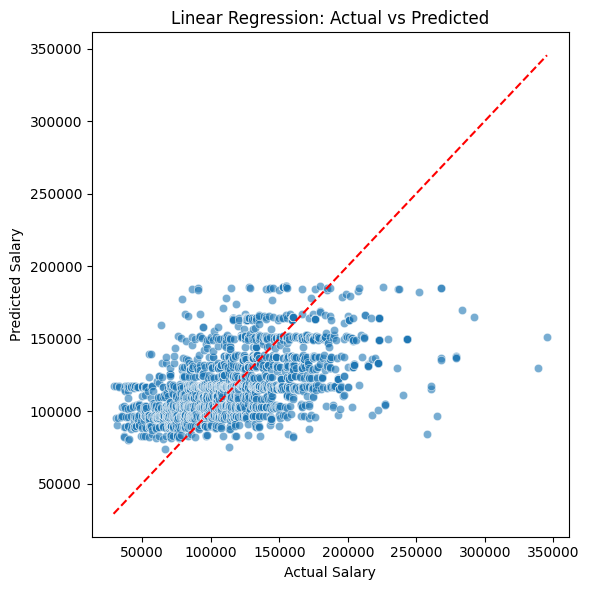

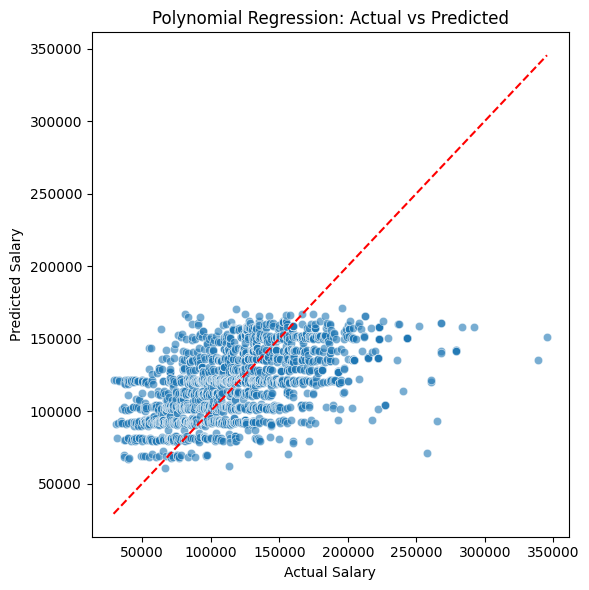

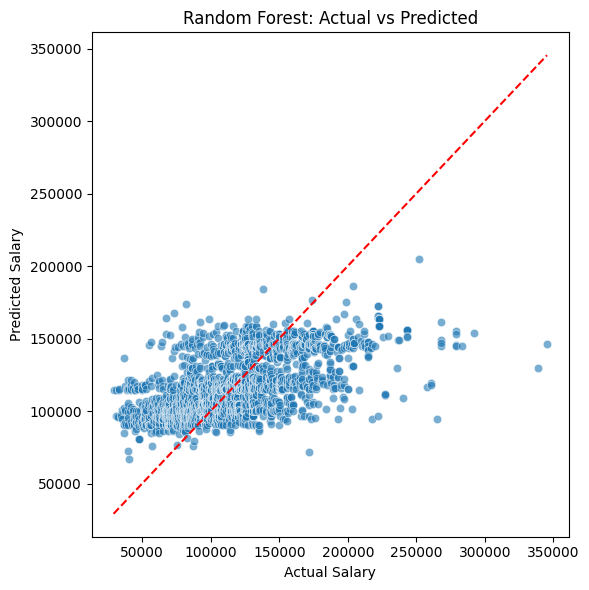

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

#predictions
pred_lr = lin_reg_fit.transform(reg_test).select("SALARY", "prediction").toPandas()
pred_lr.rename(columns={"prediction": "Predicted"}, inplace=True)

pred_poly = poly_model.transform(reg_test).select("SALARY", "prediction").toPandas()
pred_poly.rename(columns={"prediction": "Predicted"}, inplace=True)

pred_rf = rf_model.transform(reg_test).select("SALARY", "prediction").toPandas()
pred_rf.rename(columns={"prediction": "Predicted"}, inplace=True)

#plotting Actual vs Predicted
def plot_actual_vs_predicted(df, model_name):
    plt.figure(figsize=(6,6))
    sns.scatterplot(x="SALARY", y="Predicted", data=df, alpha=0.6)
    plt.plot([df["SALARY"].min(), df["SALARY"].max()],
             [df["SALARY"].min(), df["SALARY"].max()], color='red', linestyle='--')
    plt.xlabel("Actual Salary")
    plt.ylabel("Predicted Salary")
    plt.title(f"{model_name}: Actual vs Predicted")
    plt.tight_layout()
    plt.show()

plot_actual_vs_predicted(pred_lr, "Linear Regression")
plot_actual_vs_predicted(pred_poly, "Polynomial Regression")
plot_actual_vs_predicted(pred_rf, "Random Forest")


In [30]:
import math

preds_lr = lin_reg_fit.transform(reg_test).withColumnRenamed("prediction", "LR_Prediction")
preds_poly = poly_model.transform(reg_test).withColumnRenamed("prediction", "Poly_Prediction")
preds_rf = rf_model.transform(reg_test).withColumnRenamed("prediction", "RF_Prediction")

#combine predictions into one df
combined_preds = preds_lr.join(preds_poly.select("Poly_Prediction", "SALARY"), on="SALARY") \
                         .join(preds_rf.select("RF_Prediction", "SALARY"), on="SALARY")

#RMSE calculations
evaluator = RegressionEvaluator(labelCol="SALARY", metricName="rmse")

rmse_lr = evaluator.evaluate(combined_preds.withColumnRenamed("LR_Prediction", "prediction"))
rmse_poly = evaluator.evaluate(combined_preds.withColumnRenamed("Poly_Prediction", "prediction"))
rmse_rf = evaluator.evaluate(combined_preds.withColumnRenamed("RF_Prediction", "prediction"))

print(f"RMSE - Linear Regression: {rmse_lr:.2f}")
print(f"RMSE - Polynomial Regression: {rmse_poly:.2f}")
print(f"RMSE - Random Forest: {rmse_rf:.2f}")

n = reg_test.count()

#aic for lr
p_lr = len(lin_reg_fit.coefficients)
rss_lr = lin_reg_fit.summary.meanSquaredError * n
aic_lr = n * math.log(rss_lr / n) + 2 * p_lr
print(f"AIC - Linear Regression: {aic_lr:.2f}")

#aic for poly
p_poly = len(poly_model.coefficients)
rss_poly = poly_model.summary.meanSquaredError * n
aic_poly = n * math.log(rss_poly / n) + 2 * p_poly
print(f"AIC - Polynomial Regression: {aic_poly:.2f}")


# Linear
rss_lr_sum = combined_preds.withColumn("sq_err_lr", (col("SALARY") - col("LR_Prediction"))**2) \
                           .groupBy().sum("sq_err_lr").collect()[0][0]
ll_lr = -n/2 * (math.log(2*math.pi) + 1 - math.log(n) + math.log(rss_lr_sum))

# Polynomial
rss_poly_sum = combined_preds.withColumn("sq_err_poly", (col("SALARY") - col("Poly_Prediction"))**2) \
                             .groupBy().sum("sq_err_poly").collect()[0][0]
ll_poly = -n/2 * (math.log(2*math.pi) + 1 - math.log(n) + math.log(rss_poly_sum))

# Random Forest
rss_rf_sum = combined_preds.withColumn("sq_err_rf", (col("SALARY") - col("RF_Prediction"))**2) \
                           .groupBy().sum("sq_err_rf").collect()[0][0]
ll_rf = -n/2 * (math.log(2*math.pi) + 1 - math.log(n) + math.log(rss_rf_sum))

# -----------------------------
# 5. BIC calculation
# -----------------------------

# Number of parameters
k_lr = len(lin_reg_fit.coefficients) + 1
k_poly = len(poly_model.coefficients) + 1
k_rf = num_trees  # approximate

# Log-likelihoods (already computed as ll_lr, ll_poly, ll_rf)
bic_lr = -2 * ll_lr + k_lr * math.log(n)
bic_poly = -2 * ll_poly + k_poly * math.log(n)
bic_rf = -2 * ll_rf + k_rf * math.log(n)

print(f"BIC - Linear Regression: {bic_lr:.2f}")
print(f"BIC - Polynomial Regression: {bic_poly:.2f}")
print(f"BIC - Random Forest (approx.): {bic_rf:.2f}")


RMSE - Linear Regression: 32433.87
RMSE - Polynomial Regression: 30897.99
RMSE - Random Forest: 24941.84


AIC - Linear Regression: 60941.54
AIC - Polynomial Regression: 60878.13


BIC - Linear Regression: 84857.93
BIC - Polynomial Regression: 84584.34
BIC - Random Forest (approx.): 86841.66


Random Forest provides the most accurate salary predictions, achieving the lowest RMSE (24,942), while polynomial regression improves over linear regression (30,898 vs 32,434) by capturing simple nonlinear effects. 

In terms of model fit, polynomial regression shows slightly better AIC and BIC values than linear regression, indicating it balances complexity and explanatory power. Random Forest, despite a higher approximate BIC due to its complexity, outperforms both parametric models in prediction, highlighting its ability to capture complex feature interactions. 

Overall, Random Forest is best for predictive performance, whereas polynomial regression offers a reasonable trade-off between fit and interpretability.